<a href="https://colab.research.google.com/github/raiadi96/Pytorch/blob/master/BinaryTextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#creating a basic binary text classification system using IMDB Dataset.
# it classifies a movie review either as positive or negative

In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [3]:
#download the dataset

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 9s 0us/step


In [4]:
print(dataset_dir)

./aclImdb


In [5]:
print(os.listdir(dataset_dir))
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['imdbEr.txt', 'README', 'test', 'imdb.vocab', 'train']


['unsup',
 'unsupBow.feat',
 'labeledBow.feat',
 'urls_pos.txt',
 'neg',
 'pos',
 'urls_unsup.txt',
 'urls_neg.txt']

In [6]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [7]:
#removing unnecessary files
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'training',
    seed = seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [9]:
type(raw_train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [10]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [11]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [12]:
#let us create a validation set. here we set the subset to 'Validation'
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size,
    validation_split = 0.2,
    subset = 'validation',
    seed = seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [13]:
#let us create a test dataset
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size = batch_size
)

Found 25000 files belonging to 2 classes.


In [14]:
#standardization, ex : remove punctuation or html elements.
#tokenization, splitting string into token like splitting the sentence into words
#vectorization, it is the process of converting token into number

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data) #make all text lowercase
  stripped_html = tf.strings.regex_replace(lowercase, '<br />',' ') # strip out the html tags using regex replace
  return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '') #replace space charachters with space

In [15]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length
)

In [16]:
iter(raw_train_ds).next()

(<tf.Tensor: shape=(32,), dtype=string, numpy=
 array([b"Having seen most of Ringo Lam's films, I can say that this is his best film to date, and the most unusual. It's a ancient china period piece cranked full of kick-ass martial arts, where the location of an underground lair full of traps and dungeons plays as big a part as any of the characters. The action is fantastic, the story is tense and entertaining, and the set design is truely memorable. Sadly, Burning Paradise has not been made available on DVD and vhs is next-to-impossible to get your mitts on, even if you near the second biggest china-town in North America (like I do). If you can find it, don't pass it up.",
        b'Caution: May contain spoilers...<br /><br />I\'ve seen this movie 3 times & I\'ve liked it every time. Upon seeing it again, I\'m always reminded of how good it is. An HBO TV movie- very well done like most of their movies are- this would\'ve gotten Oscars for it\'s performances had it been released for gen

In [17]:
# let us remove the label that is present in the batch dataset
train_text = raw_train_ds.map(lambda x,y : x)
vectorize_layer.adapt(train_text) #this takes in the word dataset and vectorizes it according to the vectorization configutation that we had set up earlier

In [18]:
#creating a method to vectorize a text 
#input text  and label for that particular text

def vectorize_text(text, label):
  text = tf.expand_dims(text,-1)
  return vectorize_layer(text), label

text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [19]:
# we can use the formatted vectors and find it's corresponding word using get_vocabulary method
print("1285 ---> ",vectorize_layer.get_vocabulary()[1285])
print(" 673 ---> ",vectorize_layer.get_vocabulary()[673])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1285 --->  lovely
 673 --->  tells
Vocabulary size: 10000


In [20]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [21]:
#creating a cache inorder to make sure data processing does not become a bottle neck while running a model
AUTOTUNE = tf.data.experimental.AUTOTUNE 

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [22]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [23]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=tf.metrics.BinaryAccuracy(threshold=0.0))


In [25]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 11s 18ms/step - loss: 0.6656 - binary_accuracy: 0.6913 - val_loss: 0.6166 - val_binary_accuracy: 0.7724
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5497 - binary_accuracy: 0.7991 - val_loss: 0.4991 - val_binary_accuracy: 0.8216
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 0.4455 - binary_accuracy: 0.8435 - val_loss: 0.4208 - val_binary_accuracy: 0.8448
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3793 - binary_accuracy: 0.8634 - val_loss: 0.3744 - val_binary_accuracy: 0.8600
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3363 - binary_accuracy: 0.8783 - val_loss: 0.3458 - val_binary_accuracy: 0.8664
Epoch 6/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3059 - binary_accuracy: 0.8884 - val_loss: 0.3265 - val_binary_accuracy: 0.8700
Epoch 7/10
625/625 [==============================] - 4s 7ms/s

In [26]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 10s 13ms/step - loss: 0.2323 - binary_accuracy: 0.9139
Loss:  0.2323199212551117
Accuracy:  0.9138799905776978


In [29]:
# creating an accuracy plot for training and validation process
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

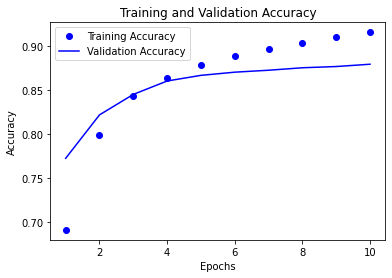

In [35]:
train_acc = history_dict['binary_accuracy']
validation_acc = history_dict['val_binary_accuracy']

epochs = range(1, len(train_acc)+1)

plt.plot(epochs,train_acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, validation_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


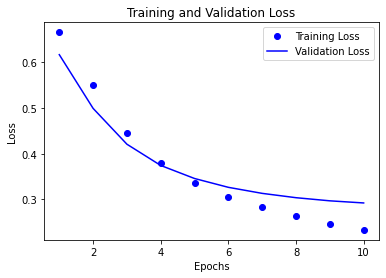

In [36]:
train_loss = history_dict['loss']
validation_loss = history_dict['val_loss']

epochs = range(1, len(train_acc)+1)

plt.plot(epochs,train_loss, 'bo', label = 'Training Loss')
plt.plot(epochs, validation_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [37]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 10s 13ms/step - loss: 0.2323 - accuracy: 0.9139
0.9138799905776978
